# **# Multilabel Text Classification**(Document Classification)


> Document classification is an example of Machine Learning in the form of Natural Language Processing. By classifying text, we are aiming to assign one or more classes or categories to a document, making it easier to manage and sort.This is an active machine learning usecase where we need to   perform multilabel text classification into 'n' classes.

Classes in which document must be classified into:


1.   Abusive
2.   Defamatory
3.   Fake text
4.   Hateful
5.   Malignant
6.   Racist
7.   Sexist


> Question arises, How can we turn this Active ML problem into a supervised ML Problem?
*  We can use the words within a document as “features” to help us predict the classification of a document.
*   To classify these documents, we would start by taking all of the words in the three documents in our training set and creating a table or vector from these words.
Then for each of the training documents, we would create a vector by assigning a 1 if the word exists in the training document and a 0 if it doesn’t, tagging the document with the appropriate class



> A more detailed look at real world document classification:


1.   The Dataset
2.   Pre-Processing
3.   Classification Model

---
## > Dataset


*   For real world document classification we need a large dataset.Large dataset is the most important thing for quality of model.  
*  Dataset for various classes are collected from:
  *   For Abusive ,Hateful,Malignant,Deformatory,Sexist from 
      kaggle's jigsaw toxic comment classification dataset.    
  *   For Racist and Sexist dataset from hatespeech.com
      (Predictive Features for Hate Speech Detection on Twitter)
 *Fake News Dataset from Kaggle.
 * HOT Dataset(Hinglish) for Abusive ,Deformatory.
  * Hatespeech dataset for twitter.(Hateful,used twitter api for tweet extraction)
  

---
## `Pre-Processing


*   Preprocessing includes refining text from the dataset.
*   Removing Stop Words,stemming does not play affect accuracy that much rather it takes lot more time,so I wrote function for stemming but not applied.
*   TfidVectorizer is used for converting into vectorizers.


---

## Classification Model.


1.   Creating model over large dataset crashed the session in my notebook ,so instead I used pipelines . 
2.   There are several methods for multiclass classification problem:
  *   OnevsRest Classifier.(using MultiNomial NB,using Logistic Regression)
  *   ChainClassifier.(Logistic Regression)
3.This can also be solved by using LSTM(RNN),word embedding, layers using keras.


---


# Conclusion
There's a little difference in accuracies of each model.(This is an approximate model)

































In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.read_csv('finaal.csv')

In [4]:
df.shape

(229406, 8)

In [5]:
#finding the no.of documents in dataset with each tag
df_toxic = df.drop(['text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,abusive,23452.0
1,defamatory,13372.0
2,fake,1115.0
3,hate,2117.0
4,malignant,1962.0
5,racist,2931.0
6,sexist,12140.0


Text(0.5, 0, 'category')

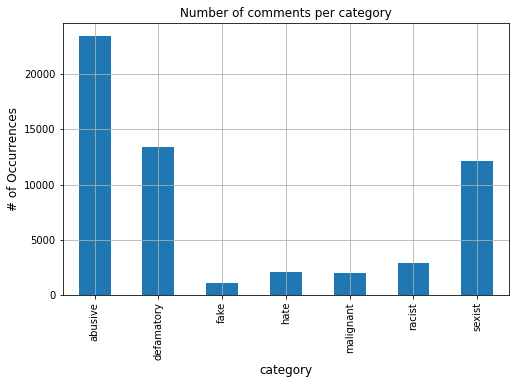

In [6]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [0]:
rowsums = df.iloc[:,:7].sum(axis=1)
x=rowsums.value_counts()

Text(0.5, 0, '# of categories')

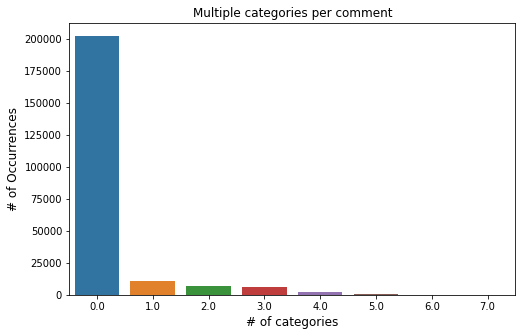

In [8]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [9]:
#percentage of documnets are not labelled
print('Percentage of documents that are not labelled:')
print(len(df[(df['abusive']==0) & (df['defamatory']==0) & (df['fake']==0) & (df['hate']== 0) & (df['malignant']==0) & (df['racist']==0) & (df['sexist']==0) ]) / len(df))

Percentage of documents that are not labelled:
0.8814154817223613


In [10]:
df.head()

,abusive,defamatory,fake,hate,malignant,racist,sexist,text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Explanation\nWhy the edits made under my usern...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D'aww! He matches this background colour I'm s...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Hey man, I'm really not trying to edit war. It..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""\nMore\nI can't make any real suggestions on ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"You, sir, are my hero. Any chance you remember..."


In [0]:
df['abusive'] = df['abusive'].astype(int)

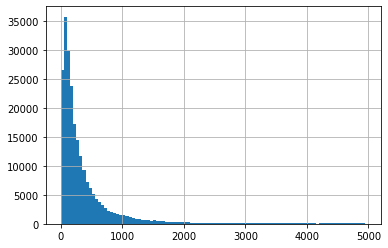

In [12]:
#finding how much words did each document ranges.
lens = df.text.str.len()
lens.hist(bins = np.arange(0,5000,50))

In [0]:
#cleaning the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [0]:
#stemming 
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def stemming(text):
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [0]:
df['text'] = df['text'].map(lambda com : clean_text(com))

In [16]:
df.head()

,abusive,defamatory,fake,hate,malignant,racist,sexist,text
0,0,0.0,0.0,0.0,0.0,0.0,0.0,explanation why the edits made under my userna...
1,0,0.0,0.0,0.0,0.0,0.0,0.0,d aww he matches this background colour i am s...
2,0,0.0,0.0,0.0,0.0,0.0,0.0,hey man i am really not trying to edit war it ...
3,0,0.0,0.0,0.0,0.0,0.0,0.0,more i can not make any real suggestions on im...
4,0,0.0,0.0,0.0,0.0,0.0,0.0,you sir are my hero any chance you remember wh...


In [0]:
categories = ['abusive','defamatory','fake','hate','malignant','racist','sexist']

In [18]:
df.sample(frac=1)

,abusive,defamatory,fake,hate,malignant,racist,sexist,text
189680,0,0.0,0.0,0.0,0.0,0.0,0.0,for your information wp polemic does not seem ...
210362,0,0.0,0.0,0.0,0.0,0.0,0.0,thx 4 ur concern on this issue referenceshttp ...
8413,0,0.0,0.0,0.0,0.0,0.0,0.0,i see nothing to keep from the list above if y...
151965,0,0.0,0.0,0.0,0.0,0.0,0.0,as sophia has patiently pointed out this artic...
154474,0,0.0,0.0,0.0,0.0,0.0,0.0,source of vandalism under the heading life as ...
...,...,...,...,...,...,...,...,...
75546,0,0.0,0.0,0.0,0.0,0.0,0.0,this is not plain english and are you telling ...
222526,0,0.0,0.0,0.0,0.0,0.0,0.0,jimbo wales are you awake he asleep please you...
13096,0,0.0,0.0,0.0,0.0,0.0,0.0,nomination i am officially nominating tenpound...
122521,0,0.0,0.0,0.0,0.0,0.0,0.0,officer names i think there needs to be more i...


In [0]:
#train-test split
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [20]:
X_train = train.text
X_test = test.text
print(X_train.shape)
print(X_test.shape)

(153702,)
(75704,)


In [0]:
#builind pipeline
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [22]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing abusive
Test accuracy is 0.9153017013632041
... Processing defamatory
Test accuracy is 0.9479023565465498
... Processing fake
Test accuracy is 0.995033287540949
... Processing hate
Test accuracy is 0.9909780196555004
... Processing malignant
Test accuracy is 0.9913742999048928
... Processing racist
Test accuracy is 0.987953080418472
... Processing sexist
Test accuracy is 0.9505838529007714


In [23]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing abusive
Test accuracy is 0.9486552890203952
... Processing defamatory
Test accuracy is 0.9657085490859135
... Processing fake
Test accuracy is 0.9967505019549826
... Processing hate
Test accuracy is 0.9920876043537991
... Processing malignant
Test accuracy is 0.9918498362041636
... Processing racist
Test accuracy is 0.9911365317552573
... Processing sexist
Test accuracy is 0.9748097854802916


In [33]:
pip install scikit-multilearn

In [0]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)
vectorizer.fit(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
x_train = vectorizer.transform(X_train)
y_train = train.drop(labels = ['text'], axis=1)

x_test = vectorizer.transform(X_test)
y_test = test.drop(labels = ['text'], axis=1)

In [0]:
classifier = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")